# Pipeline de Data Science para Baterias Li-ion (ETL + EDA + ML)

Este notebook unifica as melhores práticas de carregamento de dados, análise exploratória e modelagem preditiva para baterias 18650.

**Estrutura do Processo:**
1.  **Carregamento Híbrido:** Busca arquivos Excel/CSV no diretório `/content/dataset` (padrão do Colab) ou gera dados sintéticos.
2.  **Análise Exploratória (EDA):** Visualização de curvas de Tensão x Corrente e distribuições.
3.  **Pré-processamento:** Limpeza de outliers, engenharia de features (Potência, dV/dt) e normalização.
4.  **Machine Learning:** Classificação do tipo de bateria usando Regressão Logística, KNN e Árvores de Decisão.

In [6]:
# 1. Configuração do Ambiente
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Scikit-Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# Configurações Visuais
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Definição do Diretório de Dados
DATA_PATH = '/content/dataset'

# Criação de diretórios para saídas
dirs_to_create = [DATA_PATH, 'images', 'reports']
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)
    print(f"Diretório verificado/criado: {d}")

Diretório verificado/criado: /content/dataset
Diretório verificado/criado: images
Diretório verificado/criado: reports


In [7]:
# 2. Carregamento de Dados (Diretório Específico)

def gerar_dados_sinteticos(n_samples=5000):
    """Gera dados simulados caso não haja arquivos reais em /content/dataset."""
    print(f"\n⚠️  Nenhum arquivo encontrado em {DATA_PATH}. Gerando dados sintéticos...")
    np.random.seed(42)
    baterias = {
        'Samsung_20S': {'v': 3.6, 'i': 2.0, 'noise': 0.05},
        'LG_HG2':      {'v': 3.7, 'i': 2.5, 'noise': 0.06},
        'Sony_VTC4':   {'v': 3.5, 'i': 1.5, 'noise': 0.04},
        'Panasonic_PF':{'v': 3.8, 'i': 1.0, 'noise': 0.03}
    }
    dfs = []
    for nome, p in baterias.items():
        n = n_samples // len(baterias)
        I = np.concatenate([np.random.normal(-p['i'], 0.5, n//2), np.random.normal(p['i'], 0.5, n//2)])
        V = p['v'] + 0.1*I + np.random.normal(0, p['noise'], n)
        dfs.append(pd.DataFrame({'Time [s]': np.linspace(0, 3600, n), 'V': V, 'I': I, 'Bateria': nome}))
    return pd.concat(dfs, ignore_index=True)

def carregar_dados():
    """Carrega Excel ou CSV do diretório DATA_PATH com detecção automática."""

    # Busca arquivos apenas no diretório especificado
    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)

    arquivos = [f for f in os.listdir(DATA_PATH) if f.endswith(('.xlsx', '.xls', '.csv'))]

    if not arquivos:
        return gerar_dados_sinteticos()

    dados = []
    print(f"Processando {len(arquivos)} arquivos em {DATA_PATH}...")

    for f in arquivos:
        full_path = os.path.join(DATA_PATH, f)
        try:
            if f.endswith('.csv'):
                df = pd.read_csv(full_path)
            else:
                xls = pd.ExcelFile(full_path)
                # Busca aba com 'volt' e 'current'
                aba_valida = next((s for s in xls.sheet_names if '1_' in s or 'DCH' in s), xls.sheet_names[0])
                df = pd.read_excel(full_path, sheet_name=aba_valida)

            # Padronização de Colunas
            mapa = {c: c for c in df.columns}
            for c in df.columns:
                c_lower = str(c).lower()
                if 'volt' in c_lower: mapa[c] = 'V'
                elif 'cur' in c_lower or 'amp' in c_lower: mapa[c] = 'I'
                elif 'time' in c_lower or 'tempo' in c_lower: mapa[c] = 'Time [s]'

            df.rename(columns=mapa, inplace=True)

            if 'V' in df.columns and 'I' in df.columns:
                df['Bateria'] = os.path.splitext(f)[0]
                # Correção de sinal para Descarga (DCH)
                if 'DCH' in f.upper() or df['I'].mean() > 0:
                     df['I'] = -1 * df['I'].abs()
                dados.append(df[['Time [s]', 'V', 'I', 'Bateria']])

        except Exception as e:
            print(f"Erro em {f}: {e}")

    return pd.concat(dados, ignore_index=True) if dados else gerar_dados_sinteticos()

# Executar carregamento
df_raw = carregar_dados()
print(f"\nTotal de registros carregados: {len(df_raw)}")
df_raw.head()

Processando 51 arquivos em /content/dataset...
Erro em Samsung_18650_INR_20S_5_WLTP_25°C.csv: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Erro em LG INR18650_HG2_5_WLTP_25°C.csv: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Erro em Samsung_ICR18650-26F_5_WLTP_25°C.csv: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Erro em Samsung_18650_INR_13L_6_WLTP_0°C.csv: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Erro em Samsung_ICR18650-22P_6_WLTP_0°C.csv: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Erro em Samsung_18650_INR_20S_8_WLTP_60°C.csv: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Erro em Samsung_ICR18650-22P_7_WLTP_-15°C.csv: The truth value of a Series is ambiguous. Use a.empty, a.bool(),

,Time [s],V,I,Bateria
0,0.000000,4.173605,-0.0000,LG INR18650_HG2_1_DCH_1C
1,0.999057,4.032699,-1.7920,LG INR18650_HG2_1_DCH_1C
2,1.999115,3.998758,-2.3896,LG INR18650_HG2_1_DCH_1C
3,3.000172,3.997729,-2.9872,LG INR18650_HG2_1_DCH_1C
4,3.999229,3.995672,-2.9872,LG INR18650_HG2_1_DCH_1C


In [8]:
# 3. Pré-processamento e Feature Engineering

df_clean = df_raw.copy().dropna()

# Remoção de Ruído (Corrente muito baixa)
if not df_clean.empty:
    df_clean = df_clean[df_clean['I'].abs() > 0.05]

# Feature Engineering
print("Gerando features (Potência, dV/dt)...")
df_clean['Power'] = df_clean['V'] * df_clean['I']
df_clean['dV_dt'] = np.gradient(df_clean['V'])

# Encoding do Target
le = LabelEncoder()
df_clean['Target'] = le.fit_transform(df_clean['Bateria'])

# Normalização
features = ['V', 'I', 'Power', 'dV_dt']
X = df_clean[features].values
y = df_clean['Target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
print("Pré-processamento concluído.")

Gerando features (Potência, dV/dt)...
Pré-processamento concluído.


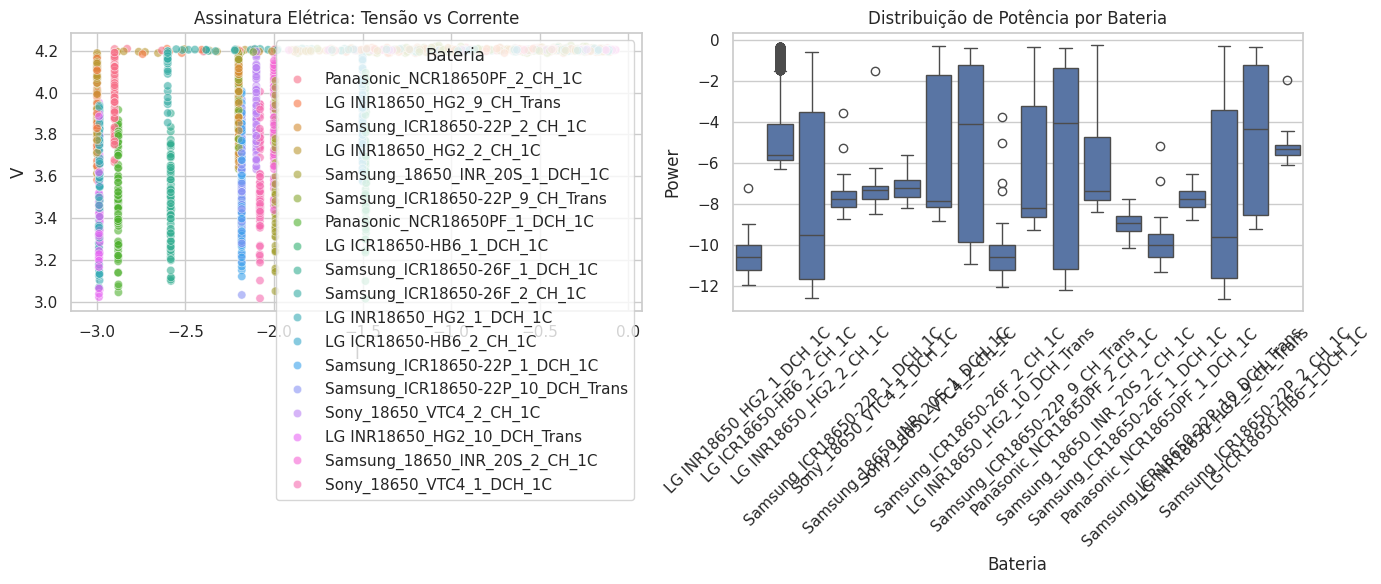

In [9]:
# 4. Análise Exploratória (EDA)

plt.figure(figsize=(14, 6))

# Plot 1: Dispersão Tensão x Corrente
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_clean.sample(min(2000, len(df_clean))), x='I', y='V', hue='Bateria', alpha=0.6)
plt.title('Assinatura Elétrica: Tensão vs Corrente')

# Plot 2: Distribuição de Potência
plt.subplot(1, 2, 2)
sns.boxplot(data=df_clean, x='Bateria', y='Power')
plt.xticks(rotation=45)
plt.title('Distribuição de Potência por Bateria')

plt.tight_layout()
plt.savefig('images/eda_summary.png')
plt.show()

Resultados da Avaliação:
------------------------------
Logistic Regression: Acc=0.3383, F1=0.3068
KNN: Acc=0.7149, F1=0.7148
Decision Tree: Acc=0.7082, F1=0.7270


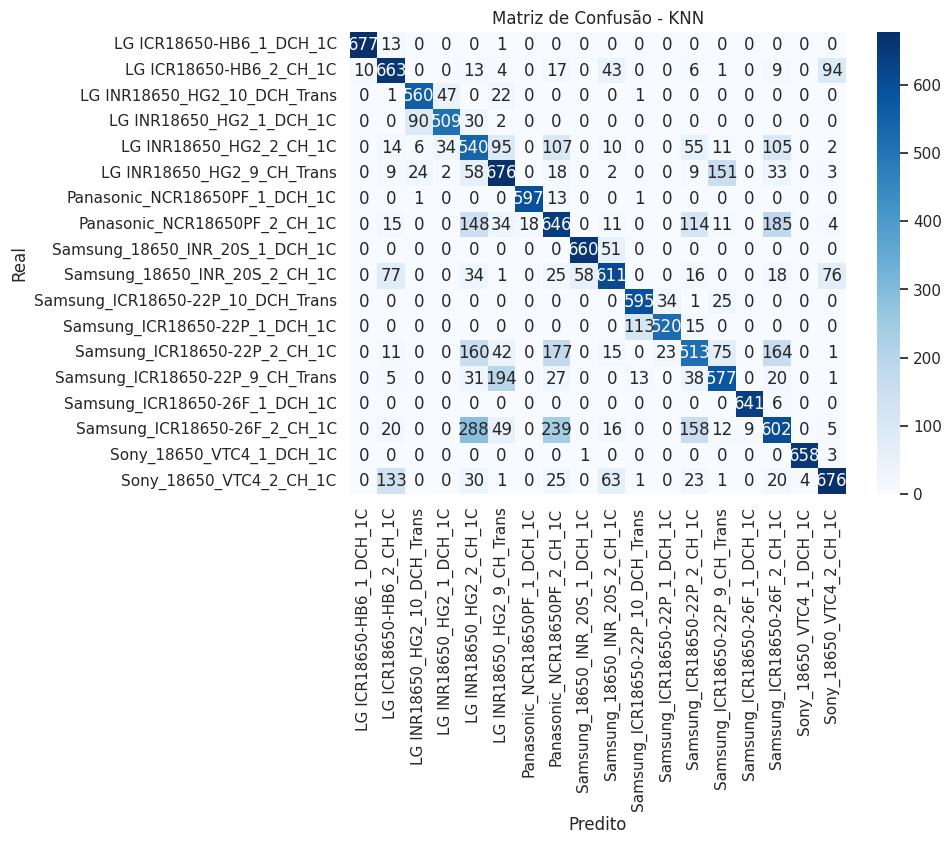

In [10]:
# 5. Modelagem e Avaliação

modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(max_depth=8)
}

melhor_acc = 0
melhor_modelo = None
nome_melhor = ""

print("Resultados da Avaliação:")
print("-"*30)

for nome, clf in modelos.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{nome}: Acc={acc:.4f}, F1={f1:.4f}")

    if acc > melhor_acc:
        melhor_acc = acc
        melhor_modelo = clf
        nome_melhor = nome

# Visualização da Matriz de Confusão do Melhor Modelo
y_pred_final = melhor_modelo.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Matriz de Confusão - {nome_melhor}')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.savefig('images/confusion_matrix.png')
plt.show()